In [3]:
import subprocess
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

class FaultType(Enum):
    ACTOR_KILLED = 0
    RECEIVE_OMISSION = 1
    SEND_OMISSION = 2

class FaultAlgorithm(Enum):
    NONE = 0
    SIMPLE_TIMEOUT = 1
    CONTROLLER = 2

class Topology(Enum):
    FAT_TREE = 0
    THIN_TREE = 1
    TORUS = 2
    GRID = 3

def getFilename(fault_type: FaultType):
    filenames = ["total_actor_kill", "total_actor_skip_receive", "total_actor_skip_send"]
    return "visualization/" + filenames[fault_type.value] + ".csv"

def getHeaders(fault_type: FaultType):
    headers = [["Количество узлов подверженных отказу", "Правильно угадано отказавших узлов", "Неправильно угадано отказавших узлов", "Среднее время восстановления","Общее время работы"],
               ["Actors corrupted (%)", "Total time (seconds)"],
               ["Actors corrupted (%)", "Total time (seconds)"]]
    return headers[fault_type.value]

def writeHeaders(fault_type: FaultType):
    filename = getFilename(fault_type)
    headers = getHeaders(fault_type)
    with open(filename, 'w') as f:
        header = headers[0]
        for i in range(1, len(headers)):
            header += ',' + headers[i]
        f.write(header + "\n")

def writeHeadersMsgStat():
    with open("visualization/total_msg_sent.csv", 'w') as f:
        f.write("Количество отправленных сообщений\n")
    with open("visualization/total_msg_received.csv", 'w') as f:
        f.write("Количество принятых сообщений\n")

def plotFaultInjectionResults(ax, ax3, ax4, ax5, fault_type: FaultType, fault_algo: FaultAlgorithm, topo: Topology):
    filename = getFilename(fault_type)
    subprocess.run(["cp", "-R", filename, "vis_data/total_actor_kill_" + fault_algo.name + "_" + topo.name + ".csv"])
    df = pd.read_csv(filename)

    headers = getHeaders(fault_type)
    df = df.sort_values(headers[0])

    ax.plot(df[headers[0]], df[headers[-1]], linestyle='-', label=fault_algo.name)
    ax3.plot(df[headers[0]], df[headers[1]], linestyle='-', label=fault_algo.name)
    ax4.plot(df[headers[0]], df[headers[2]], linestyle='-', label=fault_algo.name)
    ax5.plot(df[headers[0]], df[headers[3]], linestyle='-', label=fault_algo.name)

def runSimulation(fault_type: FaultType, job: int, fault_algo: FaultAlgorithm, topo: Topology):
    data = {
            "jobs": [
                {"topologyType": topo.name, "processes": 256, "communicationCost": 1048576, "computationCost": 500000}
            ]
        }
    with open("jobs.json", 'w') as f:
        json.dump(data, f, indent=4)
    for perc in range(0, 100, 5):
        data = {
                "faults": [
                    {"faultType": fault_type.value, "job": job, "percentage": perc, "faultAlgo": fault_algo.value}
                ]
            }
        with open('faults.json', 'w') as f:
            json.dump(data, f, indent=4)
        subprocess.run("./FaultInjectorSimGrid platform.xml > /dev/null 2>&1", shell=True)
        print(str(perc) + "%" + " done")

def showResults(fault_type: FaultType, fault_algos: list, topo: Topology):
    subprocess.run(["cmake", "--build", "."])

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    fig1 = plt.figure(figsize=(10, 4))
    ax1 = fig1.add_subplot(111)
    fig2 = plt.figure(figsize=(10, 4))
    ax2 = fig2.add_subplot(111)
    fig3 = plt.figure(figsize=(10, 4))
    ax3 = fig3.add_subplot(111)
    fig4 = plt.figure(figsize=(10, 4))
    ax4 = fig4.add_subplot(111)
    fig5 = plt.figure(figsize=(10, 4))
    ax5 = fig5.add_subplot(111)
    for el in fault_algos: 
        writeHeaders(fault_type)
        writeHeadersMsgStat()
        runSimulation(fault_type, 0, el, topo)
        plotFaultInjectionResults(ax, ax3, ax4, ax5, fault_type, el, topo)
        plotMessageStatistic(ax1, ax2, fault_type, el, topo)
    headers = getHeaders(fault_type)
    ax.set_title("Зависимость общего времени выполнения от количества узлов подверженных отказу")
    ax1.set_title("Зависимость числа сообщений от количества узлов подверженных отказу")
    ax2.set_title("Зависимость числа сообщений от количества узлов подверженных отказу")
    ax3.set_title("Right guesses")
    ax4.set_title("Wrong guesses")
    ax5.set_title("Зависимость среднего времени восстановления от количества узлов подверженных отказу")
    ax1.set_xlabel(headers[0] + ", %")
    ax1.set_ylabel("Количество отправленных сообщений, %")
    ax2.set_xlabel(headers[0] + ", %")
    ax2.set_ylabel("Количество принятых сообщений, %")
    ax3.set_xlabel(headers[0] + ", %")
    ax3.set_ylabel(headers[1] + ", %")
    ax4.set_xlabel(headers[0] + ", %")
    ax4.set_ylabel(headers[2] + ", %")
    ax5.set_xlabel(headers[0] + ", %")
    ax5.set_ylabel(headers[3] + ", сек")
    ax.set_xlabel(headers[0] + ", %")
    ax.set_ylabel(headers[-1] + ", сек")
    ax.grid(True)
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
    ax5.grid(True)
    ax.legend()
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()

    fig.savefig("visualization/total_time_" + topo.name + ".png")
    fig1.savefig("visualization/sent_messages_" + topo.name + ".png")
    fig2.savefig("visualization/receive_messages_" + topo.name + ".png")
    fig5.savefig("visualization/mean_recovery_" + topo.name + ".png")
def plotMessageStatistic(ax1, ax2, fault_type: FaultType, fault_algo: FaultAlgorithm, topo: Topology):
    filename = "visualization/total_msg_received.csv"
    subprocess.run(["cp", "-R", filename, "omagad/total_msg_received_" + fault_algo.name + "_" + topo.name  + ".csv"])
    msgReceived = pd.read_csv(filename)
    filename = "visualization/total_msg_sent.csv"
    subprocess.run(["cp", "-R", filename, "omagad/total_msg_sent_" + fault_algo.name + "_" + topo.name  + ".csv"])
    msgSent = pd.read_csv(filename)
    filename = getFilename(fault_type)
    flt = pd.read_csv(filename)

    headers = getHeaders(fault_type)

    ax1.plot(flt[headers[0]], msgSent["Количество отправленных сообщений"], linestyle='-', label=fault_algo.name)
    ax2.plot(flt[headers[0]], msgReceived["Количество принятых сообщений"], linestyle='-', label=fault_algo.name)

[ 11%] Building CXX object CMakeFiles/FaultInjectorSimGrid.dir/Entity/Task.cpp.o
[ 22%] Linking CXX executable FaultInjectorSimGrid
[100%] Built target FaultInjectorSimGrid
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done


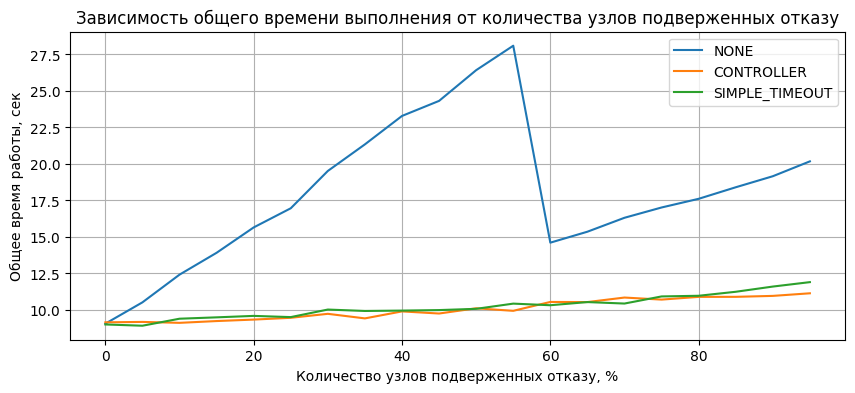

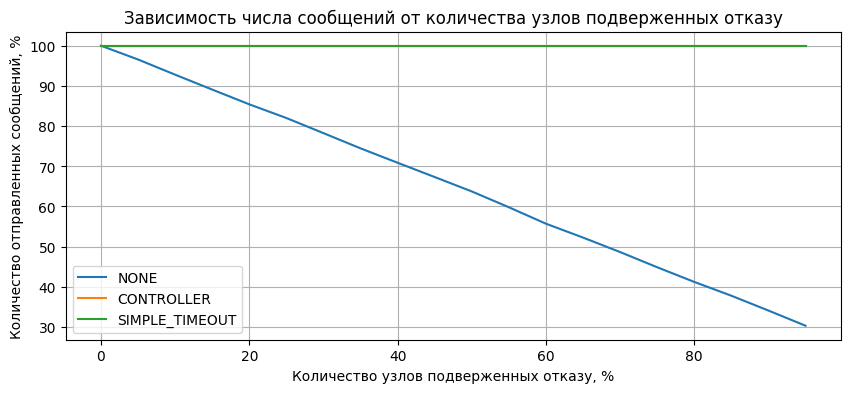

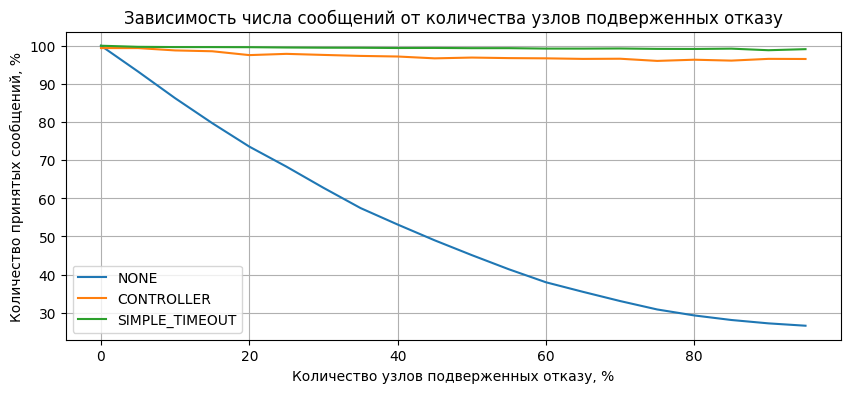

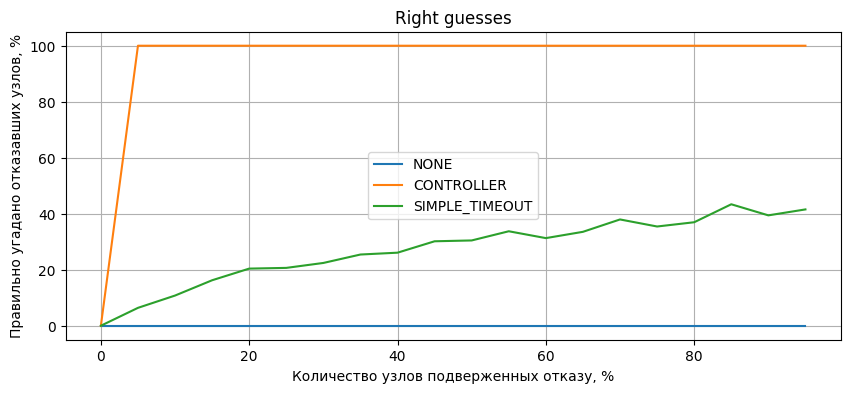

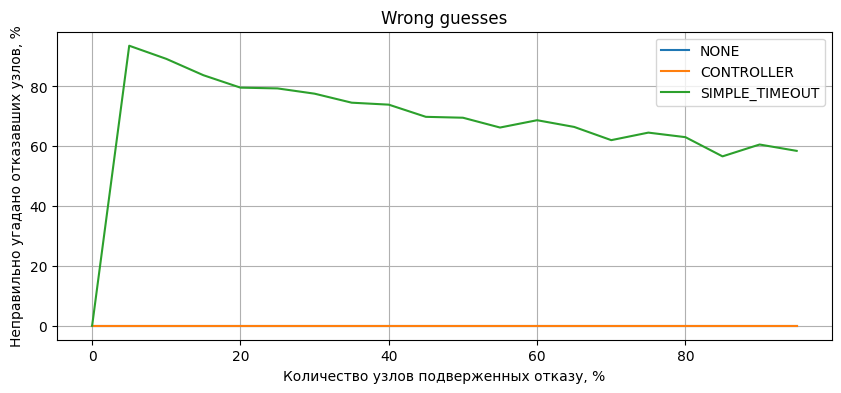

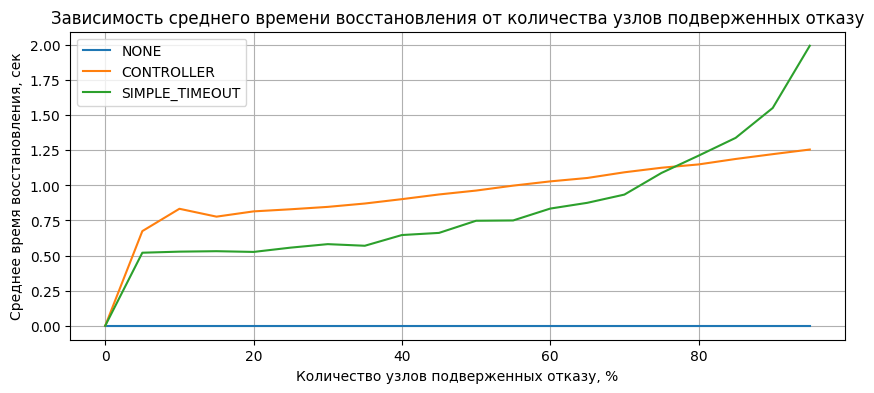

In [4]:
showResults(FaultType.ACTOR_KILLED, [FaultAlgorithm.NONE, FaultAlgorithm.CONTROLLER,FaultAlgorithm.SIMPLE_TIMEOUT], Topology.FAT_TREE)

[100%] Built target FaultInjectorSimGrid
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done


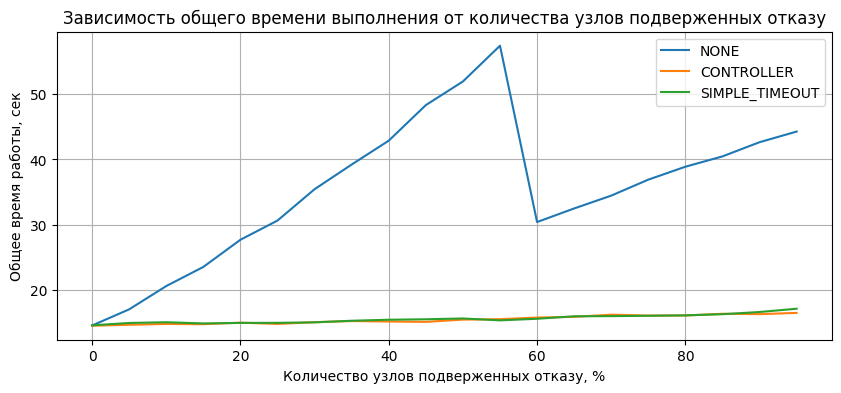

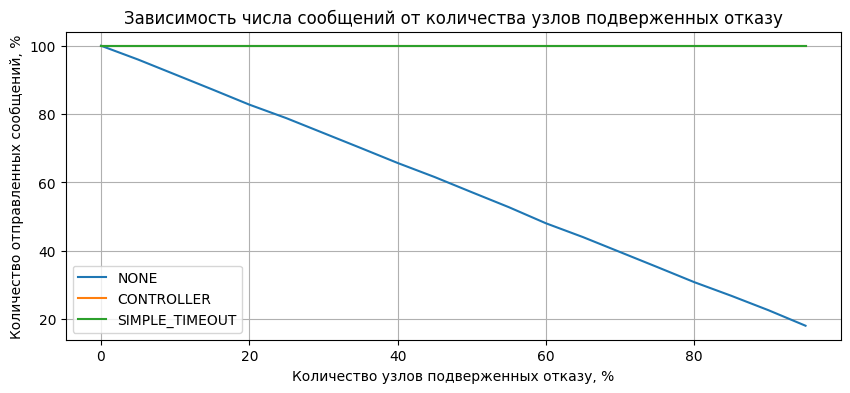

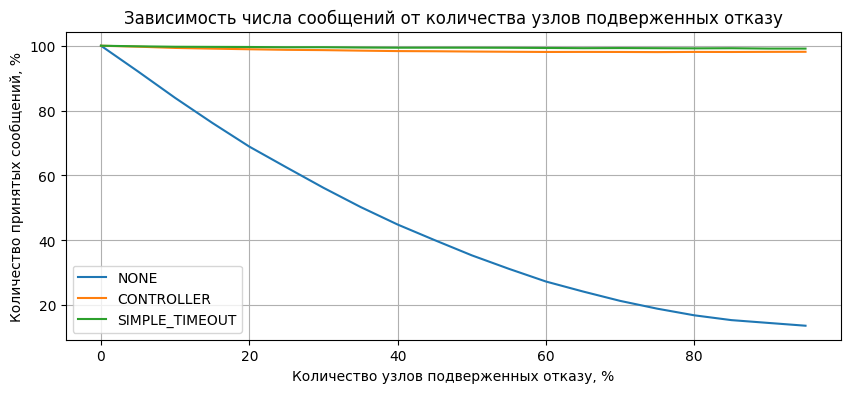

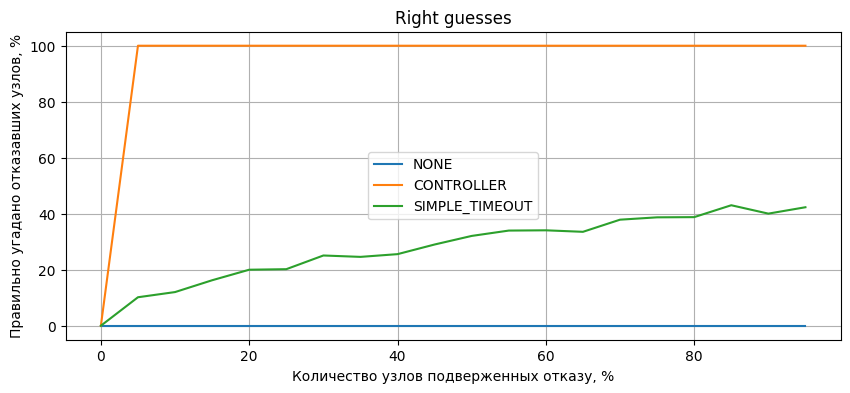

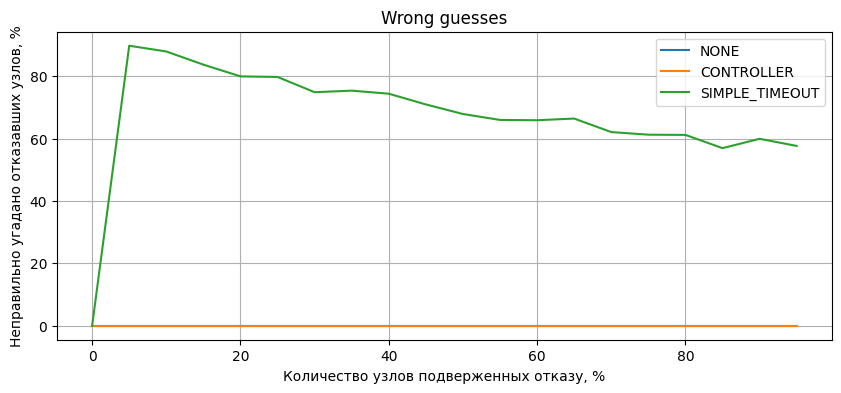

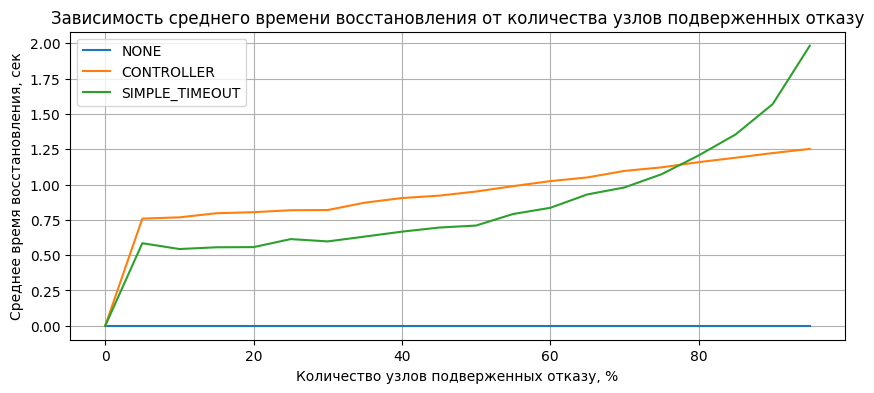

In [5]:
showResults(FaultType.ACTOR_KILLED, [FaultAlgorithm.NONE, FaultAlgorithm.CONTROLLER,FaultAlgorithm.SIMPLE_TIMEOUT], Topology.THIN_TREE)

[100%] Built target FaultInjectorSimGrid
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done


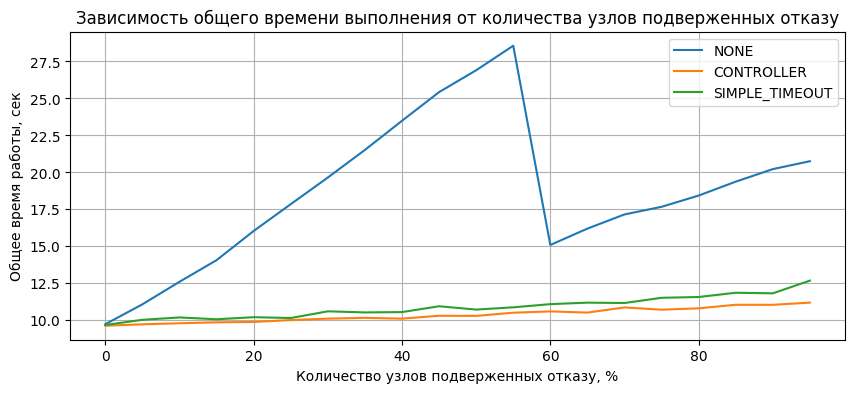

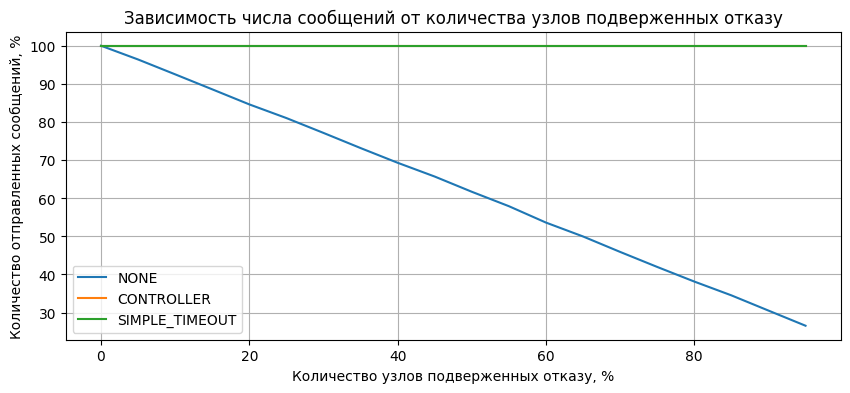

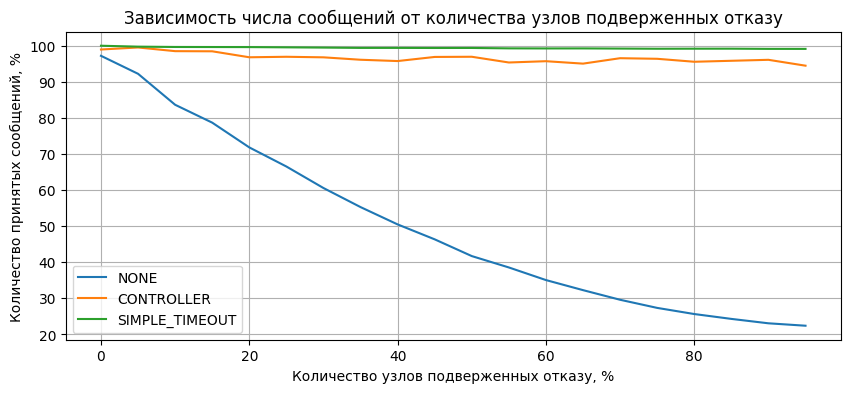

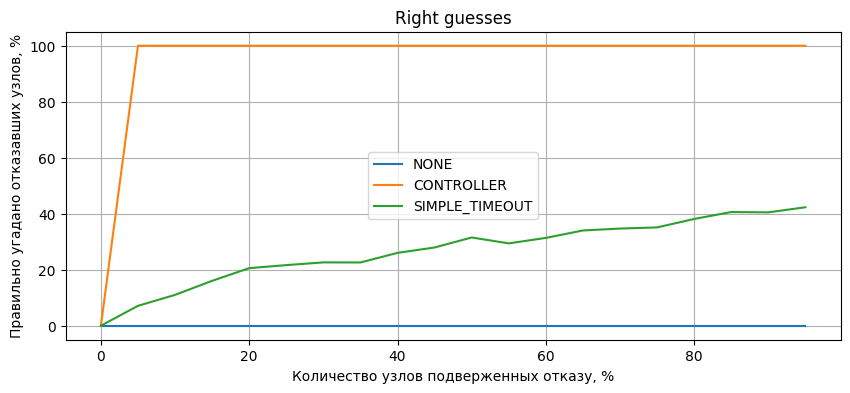

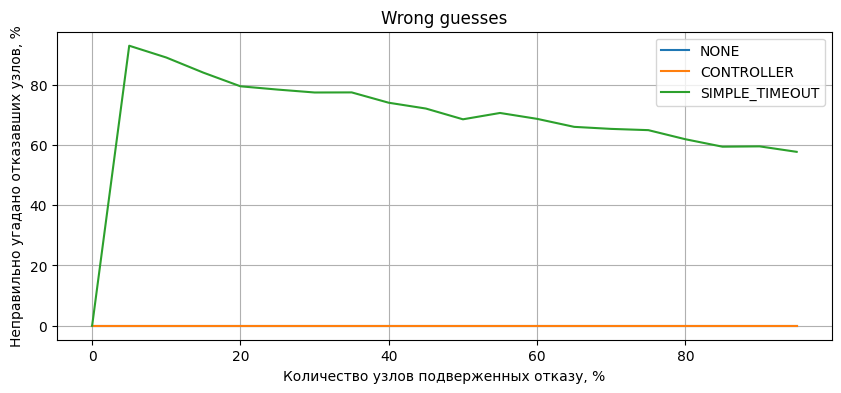

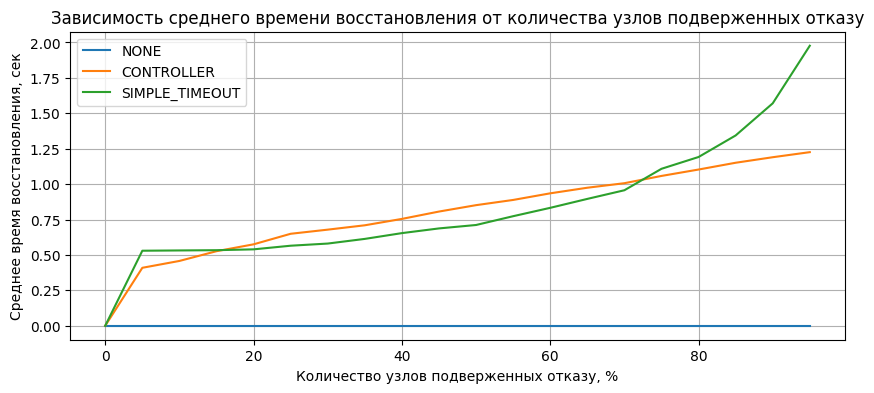

In [6]:
showResults(FaultType.ACTOR_KILLED, [FaultAlgorithm.NONE, FaultAlgorithm.CONTROLLER,FaultAlgorithm.SIMPLE_TIMEOUT], Topology.TORUS)

[100%] Built target FaultInjectorSimGrid
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done


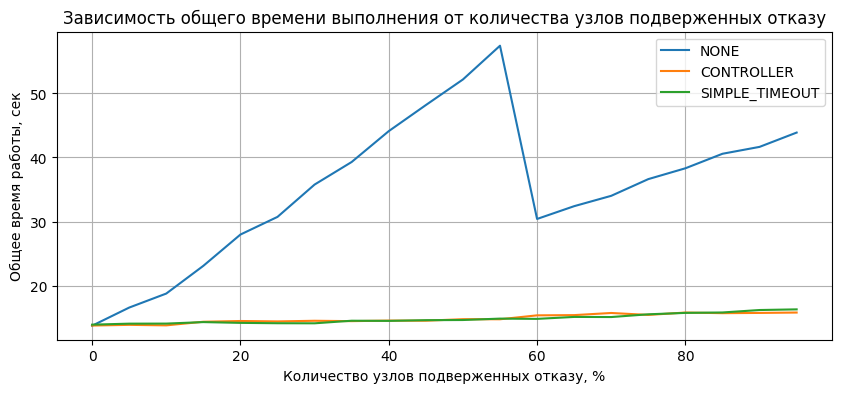

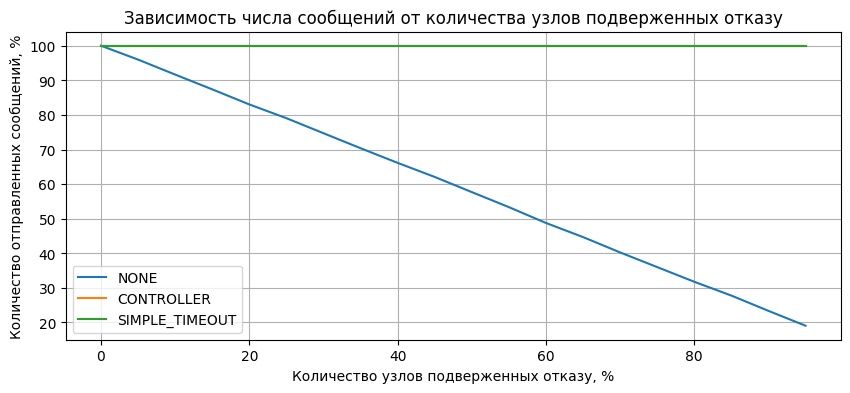

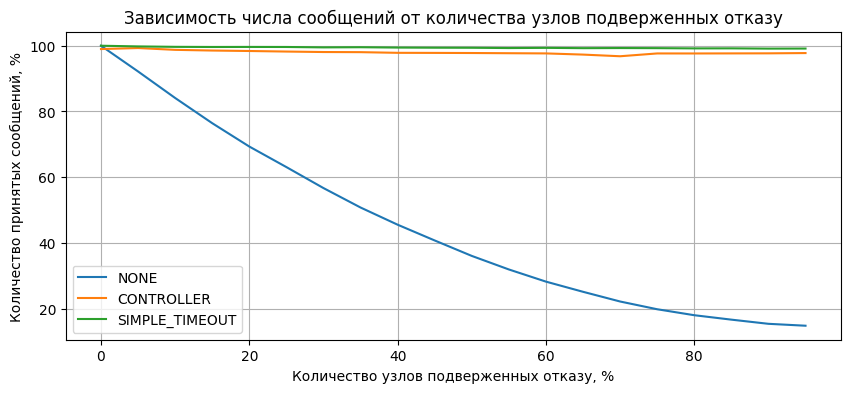

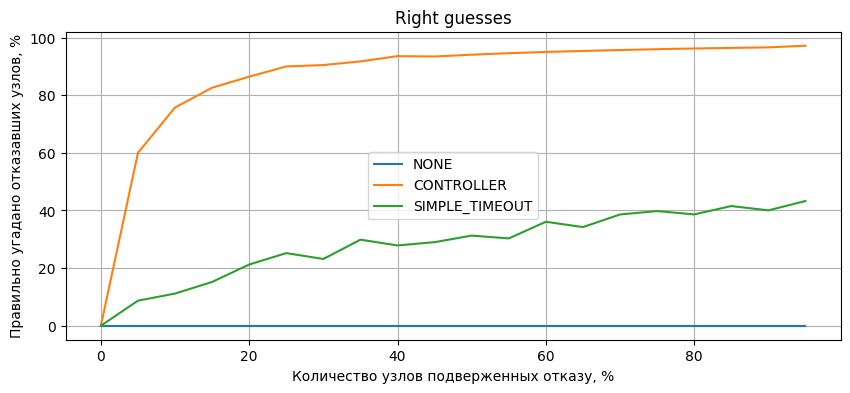

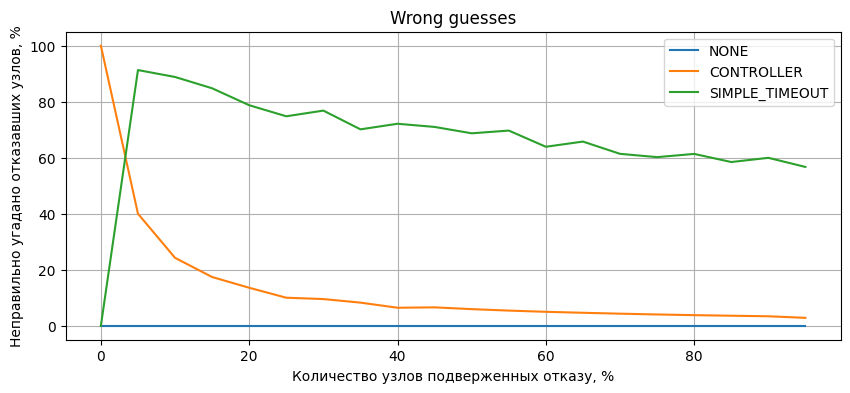

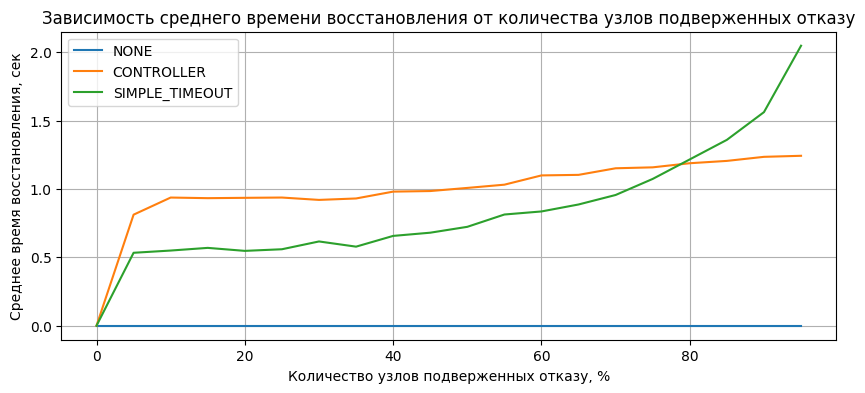

In [7]:
showResults(FaultType.ACTOR_KILLED, [FaultAlgorithm.NONE, FaultAlgorithm.CONTROLLER,FaultAlgorithm.SIMPLE_TIMEOUT], Topology.GRID)

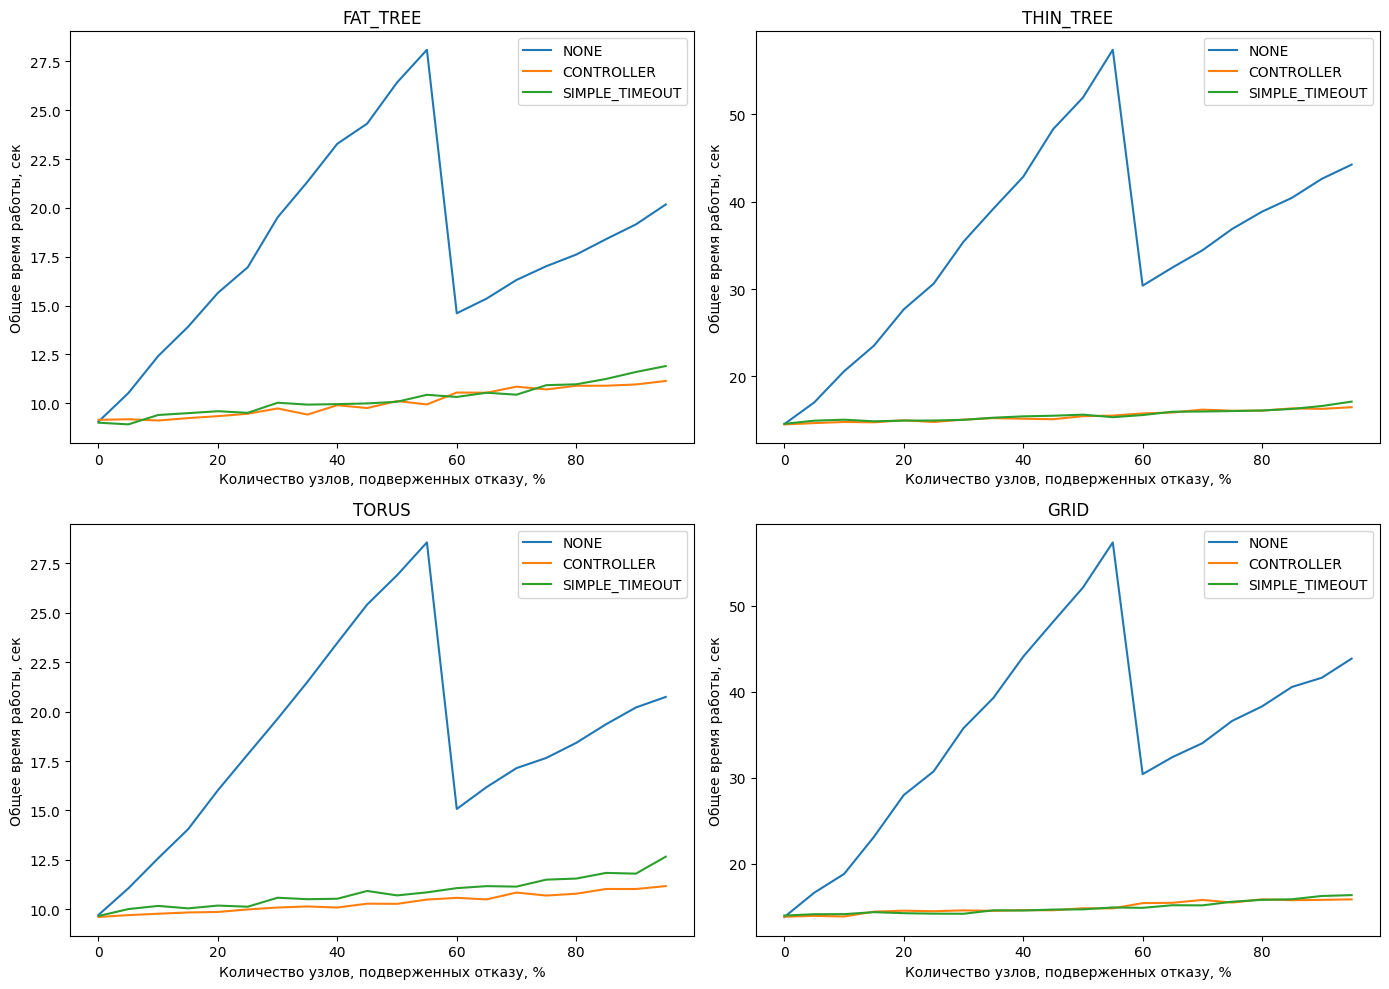

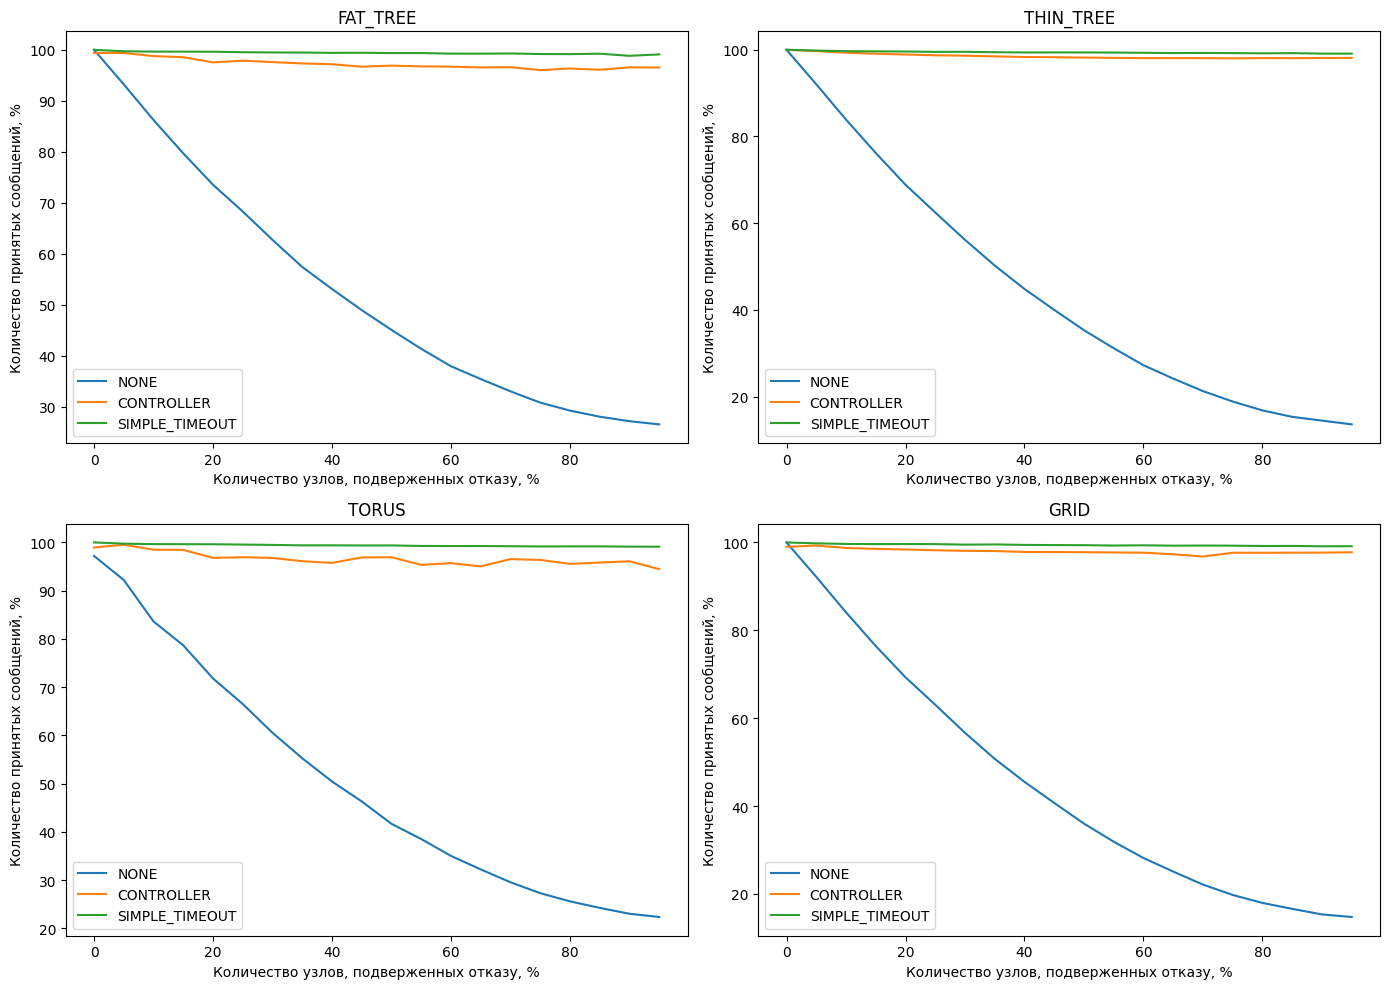

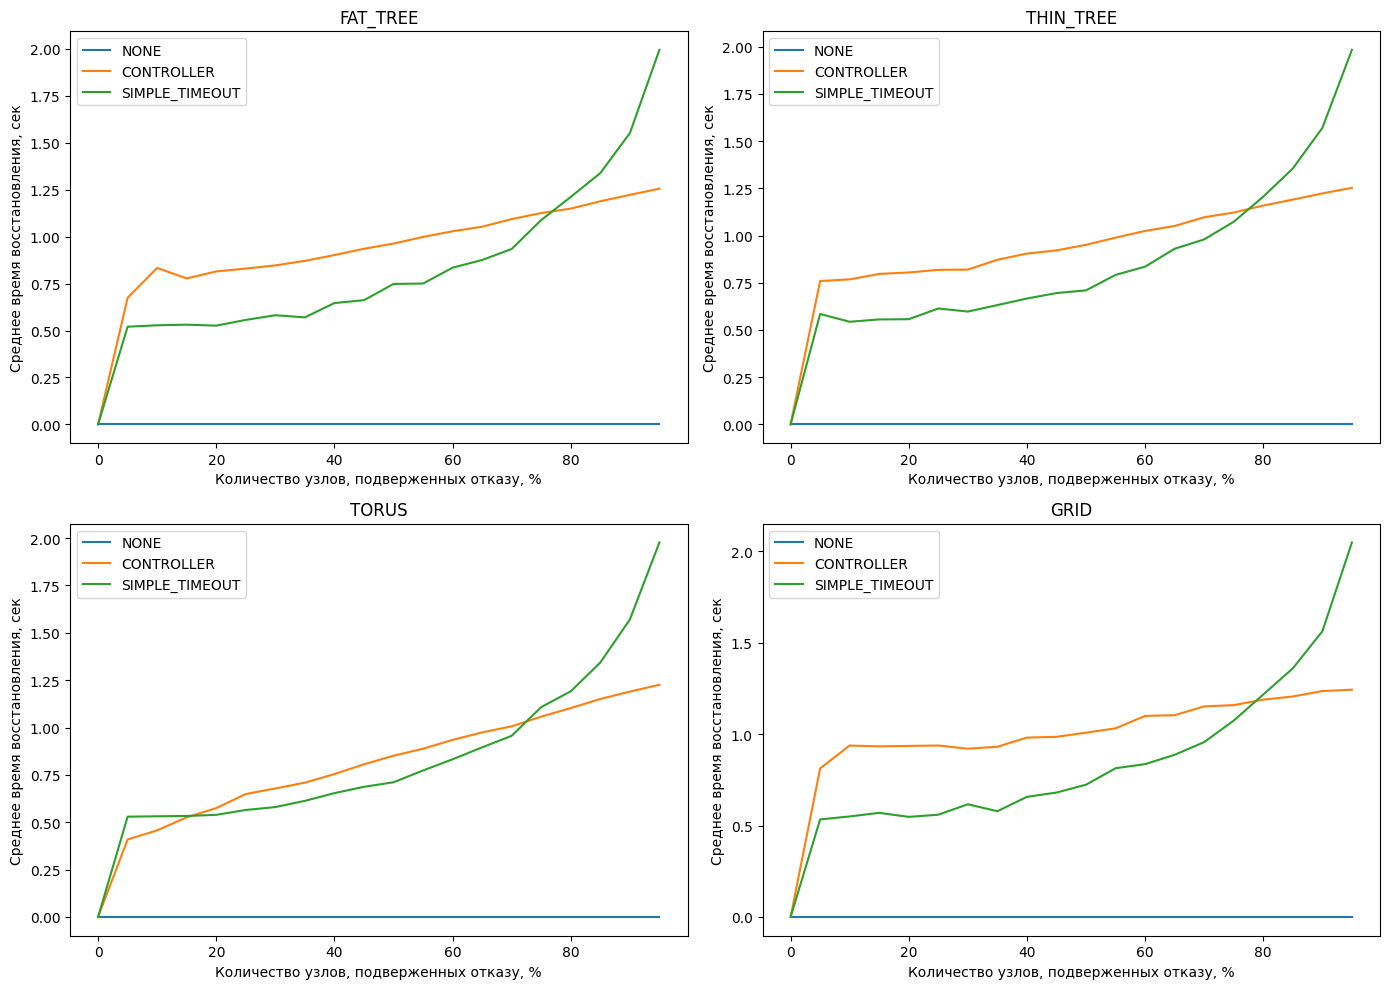

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Путь к папке с файлами
folder_path = 'omagad/'

# Возможные алгоритмы отказоустойчивости и топологии
algorithms = ['NONE', 'CONTROLLER', 'SIMPLE_TIMEOUT']
topologies = ['FAT_TREE', 'THIN_TREE', 'TORUS', 'GRID']

# Имена файлов для каждой комбинации
file_templates = {
    'total_actor_kill': 'total_actor_kill_{algorithm}_{topology}.csv',
    'total_msg_received': 'total_msg_received_{algorithm}_{topology}.csv',
    'total_msg_sent': 'total_msg_sent_{algorithm}_{topology}.csv'
}

# Загрузка данных
data = {}
for metric, template in file_templates.items():
    data[metric] = {}
    for algorithm in algorithms:
        for topology in topologies:
            file_name = template.format(algorithm=algorithm, topology=topology)
            file_path = os.path.join(folder_path, file_name)
            data[metric][(algorithm, topology)] = pd.read_csv(file_path)

# Функция для построения графиков
def plot_graphs(metric, y_label, dataset = 'total_actor_kill'):
    plt.figure(figsize=(14, 10))
    for topology in topologies:
        plt.subplot(2, 2, topologies.index(topology) + 1)
        for algorithm in algorithms:
            df = data['total_actor_kill'][(algorithm, topology)]
            df1 = data[dataset][(algorithm, topology)]
            plt.plot(df['Количество узлов подверженных отказу'], df1[metric], label=algorithm)
        plt.title(topology)
        plt.xlabel('Количество узлов, подверженных отказу, %')
        plt.ylabel(y_label)
        plt.legend()
    plt.tight_layout()
    plt.show()

# Построение графиков для общего времени работы
plot_graphs('Общее время работы', 'Общее время работы, сек')

# Построение графиков для правильно угаданных отказавших узлов
plot_graphs('Количество принятых сообщений', 'Количество принятых сообщений, %', 'total_msg_received')

# Построение графиков для среднего времени восстановления
plot_graphs('Среднее время восстановления', 'Среднее время восстановления, сек')
